**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

**Importing all required libraries**

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 12 01:07:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


**Load data from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Melanoma_data/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Melanoma_data/Test/')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Set Creation** :
Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize Data**

code to visualize one instance of all the nine classes present in the dataset 

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

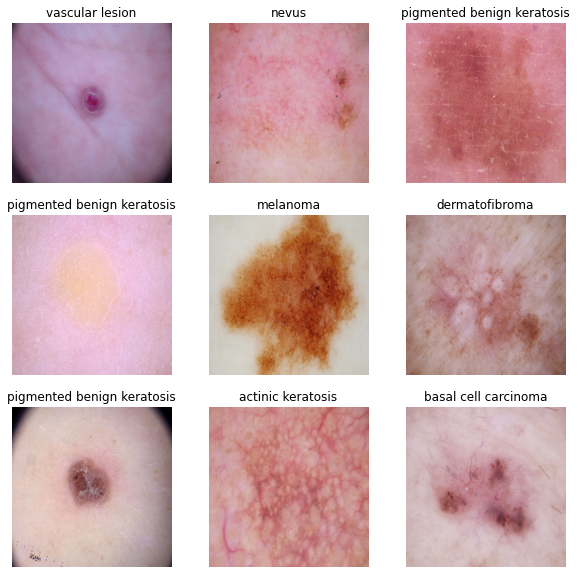

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Create the Model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [ ]:
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

**Compile the Model**

Choose an appropirate optimiser and loss function for model training 

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

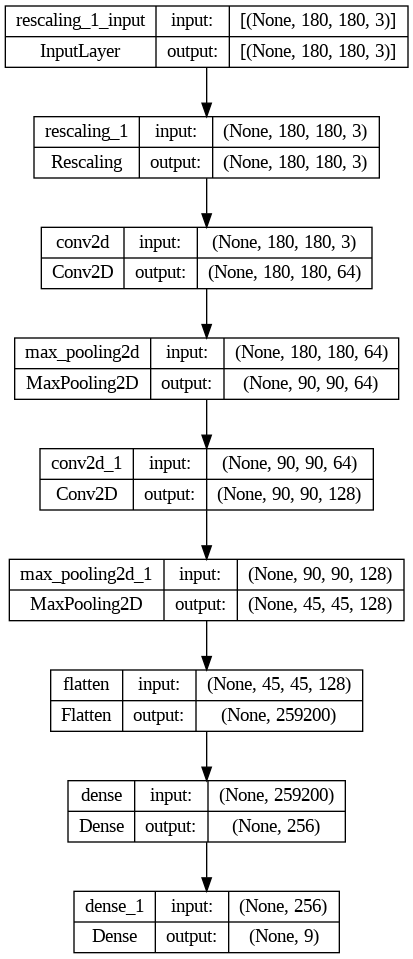

In [ ]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 137s 512ms/step - loss: 2.8215 - accuracy: 0.2796 - val_loss: 1.6748 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 1s 15ms/step - loss: 1.5943 - accuracy: 0.4375 - val_loss: 1.4901 - val_accuracy: 0.5078
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.3887 - accuracy: 0.5273 - val_loss: 1.4875 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.2675 - accuracy: 0.5547 - val_loss: 1.5527 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1329 - accuracy: 0.6094 - val_loss: 1.4440 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 0.9558 - accuracy: 0.6696 - val_loss: 1.5742 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 0.8868 - accuracy: 0.6853 - val_loss: 1.6700 - val_accuracy: 0.5123
Epoch 8/20

**Training Results**

In [ ]:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

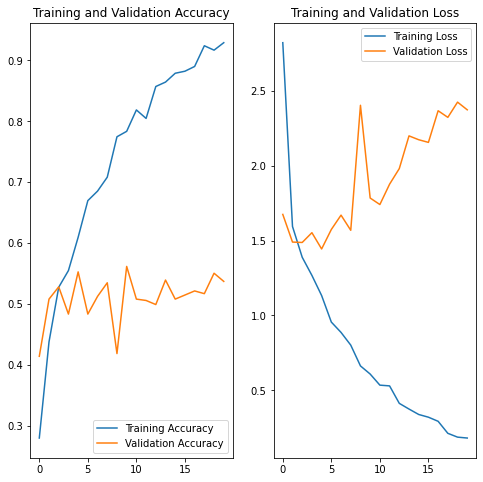

In [ ]:
plot_cnn_metrics(history,epochs)

**Observations**

1. Tranining accuracy increased consistently and reached 90% as the epochs increased however Validation accuracy increased to 50% and then it was stagnant.
2. Consistent reduction in training loss but validation loss reduced to a certain point and it was stagnant after that.
3.Disparity between Training and Validation accuracy clearly indicates Overfitting.

**Data Augmentation**

Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

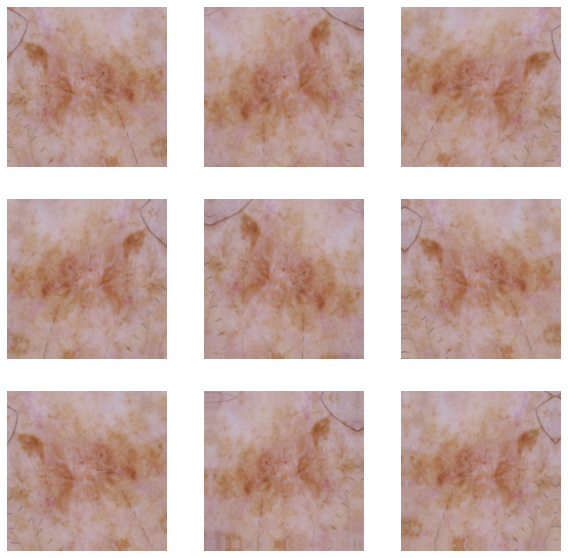

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Model Building with Augmented Data**

In [ ]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [ ]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 9s 96ms/step - loss: 2.9894 - accuracy: 0.2662 - val_loss: 1.8134 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 1.6492 - accuracy: 0.4079 - val_loss: 1.5573 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 5s 94ms/step - loss: 1.4954 - accuracy: 0.4693 - val_loss: 1.7100 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4048 - accuracy: 0.4955 - val_loss: 1.4823 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 5s 94ms/step - loss: 1.3483 - accuracy: 0.5195 - val_loss: 1.4328 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.2605 - accuracy: 0.5513 - val_loss: 1.4166 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.2408 - accuracy: 0.5474 - val_loss: 1.4428 - val_accuracy: 0.4944
Epoch 8/20
56/56 [======

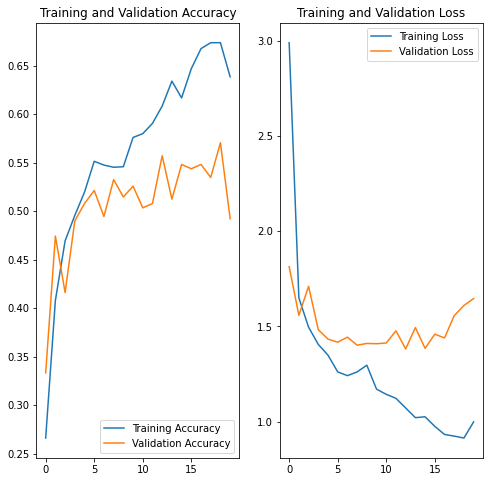

In [ ]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

**Observations**

1. Gap between Training and Validation accuracy has been narrowed down but still there is significant overfitting.
2. Overall Training accuracy has been reduced to 63% from 90%


**Model Building with Augmented Data and Dropout layer**

In [ ]:
# CNN Model
model= Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [ ]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [ ]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 9s 99ms/step - loss: 3.4153 - accuracy: 0.2327 - val_loss: 1.7399 - val_accuracy: 0.4004
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7069 - accuracy: 0.3956 - val_loss: 1.6198 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 5s 96ms/step - loss: 1.5382 - accuracy: 0.4682 - val_loss: 1.4471 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 6s 98ms/step - loss: 1.5076 - accuracy: 0.4766 - val_loss: 1.5169 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 5s 96ms/step - loss: 1.4244 - accuracy: 0.5022 - val_loss: 1.4267 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.3461 - accuracy: 0.5335 - val_loss: 1.5915 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 5s 96ms/step - loss: 1.3100 - accuracy: 0.5391 - val_loss: 1.4190 - val_accuracy: 0.5168
Epoch 8/20
56/56 [======

**Obeservations**

1. It is clear that Drop out layers reduce overfitting.
2. We are getting comparable accuracy for training and validation with the introduction of 1 drop out layers

**Validation Accuracy increased with dropout layer**

****Class Distribution****

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


Which class has the least number of samples? -  seborrheic keratosis with 77 images

Which classes dominate the data in terms of the proportionate number of samples?  -  pigmented benign keratosis with 462 images

**Handling Class Imbalance**

Rectifing class imbalances present in the training dataset with Augmentor library.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="/content/gdrive/MyDrive/Melanoma_data/Augmented_Data/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    
## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB5D05F340>: 100%|██████████| 500/500 [00:04<00:00, 114.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB381E6790>: 100%|██████████| 500/500 [00:04<00:00, 103.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/dermatofibroma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCB381F1A90>: 100%|██████████| 500/500 [00:04<00:00, 108.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCB5D0B2FA0>: 100%|██████████| 500/500 [00:17<00:00, 29.04 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/nevus/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7FCBF0258910>: 100%|██████████| 500/500 [00:16<00:00, 30.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCC080283D0>: 100%|██████████| 500/500 [00:04<00:00, 111.86 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/seborrheic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCB5D0A26A0>: 100%|██████████| 500/500 [00:07<00:00, 65.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBF022C640>: 100%|██████████| 500/500 [00:04<00:00, 116.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma_data/Augmented_Data/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCBF02AE850>: 100%|██████████| 500/500 [00:04<00:00, 123.83 Samples/s]


In [ ]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma_data/Augmented_Data/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


**Distribution of Classes after augmentation**

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [ ]:
df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

**Creating Training and Validation data set on the new augmented dataset**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.
Found 4500 files belonging to 9 classes.
Using 900 files for validation.


**New Model - after addressing class imbalance**

In [ ]:
# CNN Model
model1=Sequential()
# scaling the pixel values from 0-255 to 0-1
model1.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model1.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model1.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model1.add(layers.MaxPooling2D())
model1.add(layers.Dropout(0.5))

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model1.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model1.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model1.add(layers.Dropout(0.2))

model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(9,activation='softmax'))

In [ ]:
# Compiling the model
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 128)       73856     
                                                     

In [ ]:
# Training the model
epochs = 30
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


113/113 [==============================] - 17s 116ms/step - loss: 4.9732 - accuracy: 0.1078 - val_loss: 2.1972 - val_accuracy: 0.1067
Epoch 2/30
113/113 [==============================] - 13s 114ms/step - loss: 2.1974 - accuracy: 0.1083 - val_loss: 2.1974 - val_accuracy: 0.1067
Epoch 3/30
113/113 [==============================] - 13s 115ms/step - loss: 2.1975 - accuracy: 0.1039 - val_loss: 2.1975 - val_accuracy: 0.1067
Epoch 4/30
113/113 [==============================] - 13s 114ms/step - loss: 2.1975 - accuracy: 0.1036 - val_loss: 2.1976 - val_accuracy: 0.1067
Epoch 5/30
113/113 [==============================] - 13s 115ms/step - loss: 2.1974 - accuracy: 0.1067 - val_loss: 2.1976 - val_accuracy: 0.1067
Epoch 6/30
113/113 [==============================] - 13s 116ms/step - loss: 2.1974 - accuracy: 0.1075 - val_loss: 2.1977 - val_accuracy: 0.1067
Epoch 7/30
113/113 [==============================] - 13s 116ms/step - loss: 2.1974 - accuracy: 0.1100 - val_loss: 2.1977 - val_accuracy: 0.1

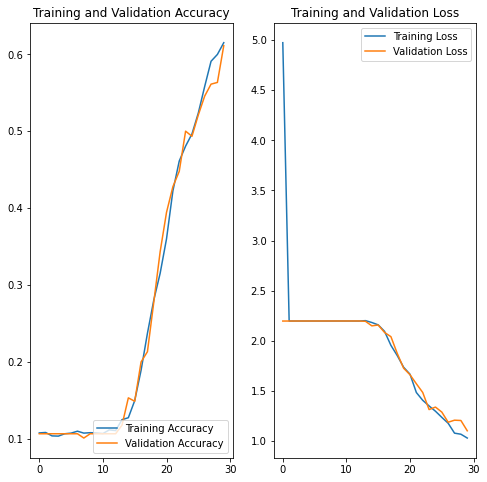

In [ ]:
# Visualizing model results
plot_cnn_metrics(history1,epochs)

**Observations**

1. Difference in accuracy between training and validation is negligible
2. Overfitting has been addressed and reduction in accuracy disparity is a clear sign
3. Class balancing treatment provides a more robust model

